# Channel Charting

In [1]:
import multiprocessing as mp
import os
import espargos_0007
import cluster_utils
import CCEvaluation
import FeatureEngineering
import neural_network_utils
import numpy as np
import tensorflow as tf

2025-04-11 20:23:30.383958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-11 20:23:30.404943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-11 20:23:30.411385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 20:23:30.427471: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 20:23:31.398884: W tensorflow/compiler/tf2

### Load Datasets, Clutter Channel and AoA Estimates

In [2]:
# Loading all the datasets can take some time...
training_set_robot = espargos_0007.load_dataset(espargos_0007.TRAINING_SET_ROBOT_FILES)
test_set_robot = espargos_0007.load_dataset(espargos_0007.TEST_SET_ROBOT_FILES)
test_set_human = espargos_0007.load_dataset(espargos_0007.TEST_SET_HUMAN_FILES)

all_datasets = training_set_robot + test_set_robot + test_set_human

  0%|          | 0/3 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


I0000 00:00:1744403013.157478   72814 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744403013.211476   72814 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744403013.211871   72814 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744403013.215398   72814 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Loading espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


2025-04-11 20:23:56.041572: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loading espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/1 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-randomwalk-2.tfrecords


2025-04-11 20:24:10.799040: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/1 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-human-helmet-randomwalk-1.tfrecords


In [3]:
for dataset in all_datasets:
    dataset_name = os.path.basename(dataset["filename"])
    dataset["clutter_acquisitions"] = np.load(os.path.join("clutter_channel_estimates", dataset_name + ".npy"))
    if dataset in training_set_robot:
        dataset["cluster_aoa_angles"] = np.load(os.path.join("aoa_estimates", dataset_name + ".aoa_angles.npy"))
        dataset["cluster_aoa_powers"] = np.load(os.path.join("aoa_estimates", dataset_name + ".aoa_powers.npy"))

In [4]:
for dataset in all_datasets:
    cluster_utils.cluster_dataset(dataset)

Clustering dataset espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


  0%|          | 0/174647 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


  0%|          | 0/204711 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/103524 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-randomwalk-2.tfrecords


  0%|          | 0/139427 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-human-helmet-randomwalk-1.tfrecords


  0%|          | 0/33011 [00:00<?, ?it/s]

### Feature Engineering

Pre-compute features for neural network training in NumPy

In [5]:
FeatureEngineering.precompute_features(all_datasets)

Pre-computing training features for 43620 datapoints in total


  0%|          | 0/43620 [00:00<?, ?it/s]

### Loss Function

In [6]:
# Heuristic: Uncertainty about angle of arrival as a function of root-MUSIC AoA estimate power
def aoa_power_to_kappa(aoa_power):
    return 5 * aoa_power**6

In [7]:
def bessel_i0_approx(x):
	# See Eq. (10) in https://iopscience.iop.org/article/10.1088/1742-6596/1043/1/012003/pdf
	return tf.math.cosh(x) / (1 + x**2 / 4)**(1/4) * (1 + 0.24273 * x**2) / (1 + 0.43023 * x**2)

class ChannelChartingLoss(tf.keras.losses.Loss):
    def __init__(self, classical_weight, aoa_angles, aoa_powers, height, dissimilarity_matrix, dissimilarity_margin = 1, name = "CCLoss"):

        super().__init__(name = name)

        self.classical_weight = classical_weight
        self.height = height
        self.dissimilarity_matrix_tensor = tf.constant(dissimilarity_matrix, dtype = tf.float32)
        self.dissimilarity_margin = dissimilarity_margin
        self.estimated_aoas_tensor = tf.constant(aoa_angles, dtype = tf.float32)
        self.aoa_powers_tensor = tf.constant(aoa_powers, dtype = tf.float32)

        self.centers_tensor = tf.constant(espargos_0007.array_positions, dtype = tf.float32)
        self.normalvectors_tensor = tf.constant(espargos_0007.array_normalvectors, dtype = tf.float32)
        self.rightvectors_tensor = tf.constant(espargos_0007.array_rightvectors, dtype = tf.float32)
        self.centroid_tensor = tf.constant(espargos_0007.centroid, dtype = tf.float32)[tf.newaxis, :2]

    def classical(self, pos, aoas, aoa_powers):
        pos_with_height = tf.concat([pos + self.centroid_tensor, self.height * tf.ones(tf.shape(pos)[0])[:, tf.newaxis]], 1)

        # "relative" has shape (number of positions, number of arrays, 3 spatial dimensions)
        relative_pos = pos_with_height[:,tf.newaxis,:] - self.centers_tensor

        # Compute ideal 2D AoAs at given positions, shape: (number of positions, number of arrays)
        normal = tf.einsum("dax,ax->da", relative_pos, self.normalvectors_tensor)
        right = tf.einsum("dax,ax->da", relative_pos, self.rightvectors_tensor)
        ideal_aoas = tf.math.atan2(right, normal)

        # Compute AoA likelihoods based on von Mises distribution
        kappas = aoa_power_to_kappa(aoa_powers)
        aoa_likelihoods = tf.exp(kappas * tf.cos(ideal_aoas - aoas)) / (2 * np.pi * bessel_i0_approx(kappas))

        return tf.math.reduce_prod(aoa_likelihoods, axis = -1)

    def siamese(self, pos_A, pos_B, dissimilarities):
        distances_pred = tf.math.sqrt(tf.math.reduce_sum(tf.square(pos_A - pos_B), axis = 1))
        return tf.reduce_mean(tf.square(distances_pred - dissimilarities) / (dissimilarities + self.dissimilarity_margin))

    def call(self, y_true, y_pred):
        # This is an ugly workaround, the loss function always gets y_pred as float, convert back to integer for index
        # This works as long as CSI tensor is not absolutely huge (16M+ entries), which can be assumed.
        index_A = tf.cast(y_true[:,0], tf.int32)
        index_B = tf.cast(y_true[:,1], tf.int32)

        pos_A, pos_B = (y_pred[:,:2], y_pred[:,2:])

        # Siamese loss
        dissimilarities = tf.gather_nd(self.dissimilarity_matrix_tensor, tf.transpose([index_A, index_B]))
        siamese_loss = self.siamese(pos_A, pos_B, dissimilarities)

        # Classical loss
        aoa_A = tf.gather(self.estimated_aoas_tensor, index_A)
        aoa_B = tf.gather(self.estimated_aoas_tensor, index_B)
        aoa_power_A = tf.gather(self.aoa_powers_tensor, index_A)
        aoa_power_B = tf.gather(self.aoa_powers_tensor, index_B)

        classical_loss = -tf.reduce_sum(
            self.classical(pos_A, aoa_A, aoa_power_A) +
            self.classical(pos_B, aoa_B, aoa_power_B)
        )

        # Combination
        return self.classical_weight * classical_loss + (1 - self.classical_weight) * siamese_loss

### Neural Network Training

In [8]:
def combine_datasets(datasets, for_training = False):
    combined = dict()
    combined["cluster_features"] = []
    combined["cluster_positions"] = []
    heights = []
    if for_training:
        combined["cluster_aoa_angles"] = []
        combined["cluster_aoa_powers"] = []

    for dataset in datasets:
        combined["cluster_features"].append(dataset["cluster_features"])
        combined["cluster_positions"].append(dataset["cluster_positions"][:,:2])
        heights.append(dataset["cluster_positions"][:,2])
        if for_training:
            combined["cluster_aoa_angles"].append(dataset["cluster_aoa_angles"])
            combined["cluster_aoa_powers"].append(dataset["cluster_aoa_powers"])

    combined["cluster_features"] = np.concatenate(combined["cluster_features"])
    combined["cluster_positions"] = np.concatenate(combined["cluster_positions"])
    combined["mean_height"] = np.mean(np.concatenate(heights))
    if for_training:
        combined["cluster_aoa_angles"] = np.concatenate(combined["cluster_aoa_angles"])
        combined["cluster_aoa_powers"] = np.concatenate(combined["cluster_aoa_powers"])

    if for_training:
        training_set_name = espargos_0007.hash_dataset_names(datasets)
        combined["dissimilarity_matrix"] = np.load(os.path.join("dissimilarity_matrices", training_set_name + ".geodesic_meters.npy"))

    return combined

In [9]:
robot_training_data = combine_datasets(training_set_robot, for_training = True)
robot_test_data = combine_datasets(test_set_robot)
human_test_data = combine_datasets(test_set_human)

In [10]:
def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:,:-1]
    A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond = None)
    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(channel_chart_pos)

In [19]:
class ChartPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, featprov, position_labels, fcf, augmented = True):
        self.featprov = featprov
        self.position_labels = position_labels
        self.fcf = fcf
        self.augmented = augmented
   
    def on_epoch_end(self, epoch, logs = None):
        position_predictions = self.fcf.predict(self.featprov(np.arange(self.position_labels.shape[0]))) + espargos_0007.centroid[:2]
        suptitle = f"Epoch {epoch}"

        if self.augmented:
            position_predictions_trans = position_predictions
        else:
            suptitle = suptitle + " (after opt. aff. trans.)"
            position_predictions_trans = affine_transform_channel_chart(self.position_labels, position_predictions)

        errorvectors, errors, mae, cep = CCEvaluation.compute_localization_metrics(position_predictions_trans, self.position_labels)
        title = f"Unsupervised: MAE = {mae:.3f}m, CEP = {cep:.3f}m"
        CCEvaluation.plot_colorized(position_predictions_trans, self.position_labels, suptitle = suptitle, title = title)

def train_model(training_data, augmented = True):
    # Training Hyperparameters
    STEPS_PER_EPOCH = 200
    EPOCHS = 10
    LEARNING_RATE_INITIAL = 1e-2
    LEARNING_RATE_FINAL = 1e-5
    BATCH_SIZES = [64, 128, 256, 512, 1024, 2048, 4096]
    
    training_features = training_data["cluster_features"]
    sample_count = training_features.shape[0]

    # Step 1: Construct forward charting function (FCF) regression model
    fcf_model = neural_network_utils.construct_model(input_shape = FeatureEngineering.FEATURE_SHAPE, name = "ChannelChartingModel")

    # Step 2: Embed FCF model into Siamese training model that provides features as neural network inputs
    input_A = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    input_B = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    featprov = neural_network_utils.FeatureProviderLayer(dtype = tf.int64)
    featprov.set_features(training_features)
    csi_A = featprov(input_A)
    csi_B = featprov(input_B)
    embedding_A = fcf_model(csi_A)
    embedding_B = fcf_model(csi_B)
    output = tf.keras.layers.concatenate([embedding_A, embedding_B], axis = 1)
    siamese_model = tf.keras.models.Model([input_A, input_B], output, name = "SiameseNeuralNetwork")

    loss = ChannelChartingLoss(
        classical_weight = 0.05 if augmented else 0.0,
        aoa_angles = training_data["cluster_aoa_angles"],
        aoa_powers = training_data["cluster_aoa_powers"],
        height = training_data["mean_height"],
        dissimilarity_matrix = training_data["dissimilarity_matrix"],
        dissimilarity_margin = np.quantile(training_data["dissimilarity_matrix"], 0.01),
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate = LEARNING_RATE_INITIAL,
                    decay_steps = EPOCHS * STEPS_PER_EPOCH,
                    decay_rate = LEARNING_RATE_FINAL / LEARNING_RATE_INITIAL,
                    staircase = False)
    
    siamese_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule), loss = loss)

    # Step 3: Actually train model
    def random_index_batch_generator():
        batch_count = 0
        while True:
            #print(batch_count, int(np.floor(batch_count / (TRAINING_BATCHES + 1) * len(BATCH_SIZES))))
            batch_size = BATCH_SIZES[min(int(np.floor(batch_count / (EPOCHS * STEPS_PER_EPOCH + 1) * len(BATCH_SIZES))), len(BATCH_SIZES) - 1)]
            batch_count = batch_count + 1
            #print("batch_size =", batch_size)
            indices_A = np.random.randint(sample_count, size = 256)
            indices_B = np.random.randint(sample_count, size = 256)
            yield (indices_A, indices_B), tf.stack([indices_A, indices_B], axis = 1)

    training_dataset = tf.data.Dataset.from_generator(random_index_batch_generator,
        output_signature = ((tf.TensorSpec(shape = (None,), dtype = tf.int32), tf.TensorSpec(shape = (None,), dtype = tf.int32)),
        tf.TensorSpec(shape = (None, 2), dtype = tf.int32)))

    plot_callback = ChartPlotCallback(featprov, training_data["cluster_positions"], fcf_model, augmented = augmented)
    siamese_model.fit(training_dataset, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, callbacks = [plot_callback])

    return fcf_model

### Un-Augmented Model: Only dissimilarity-based, do not use AoA estimates

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


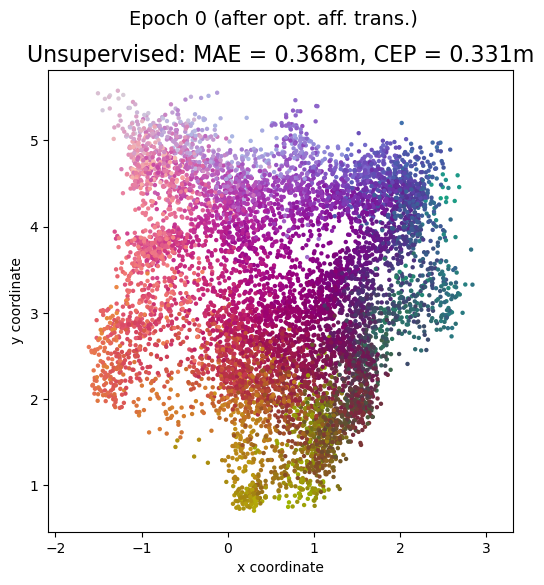

200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.3095
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


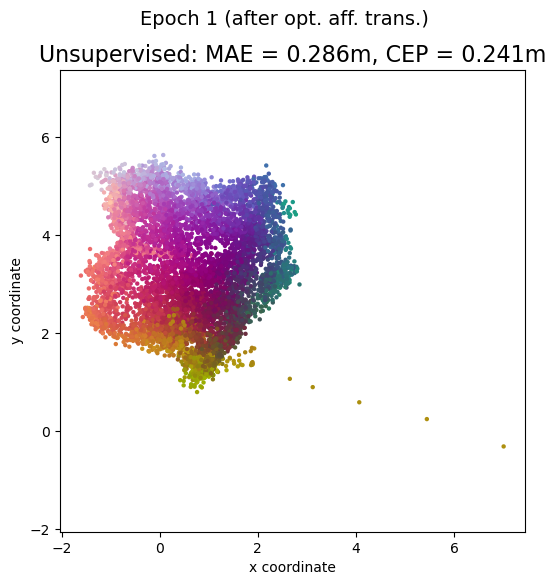

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0909
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


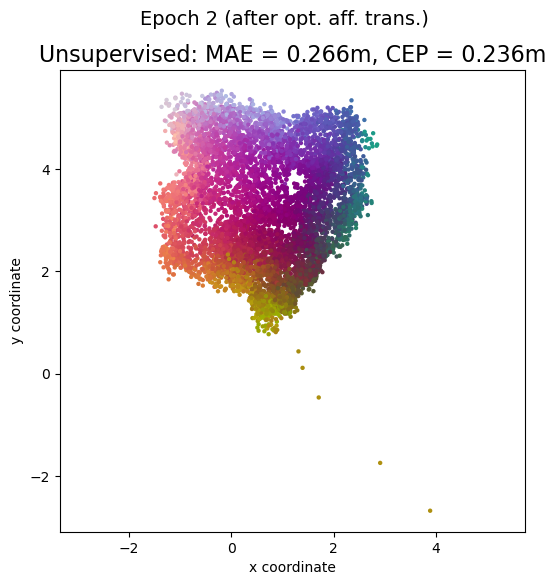

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0853
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


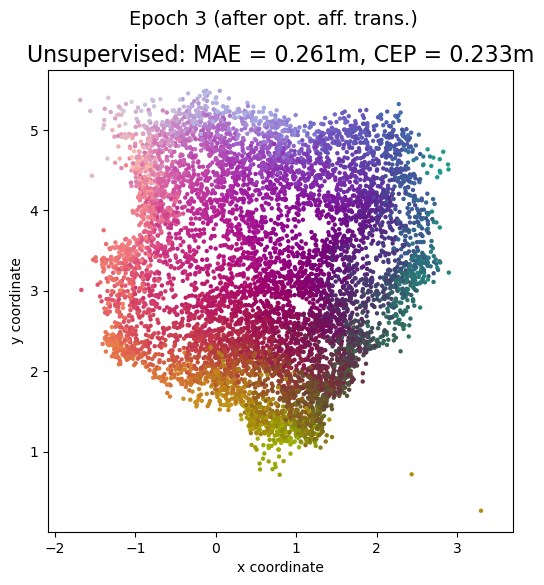

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0796
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


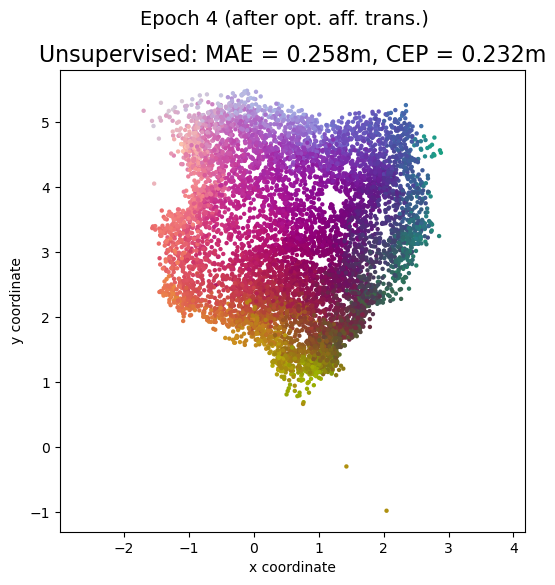

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0799
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


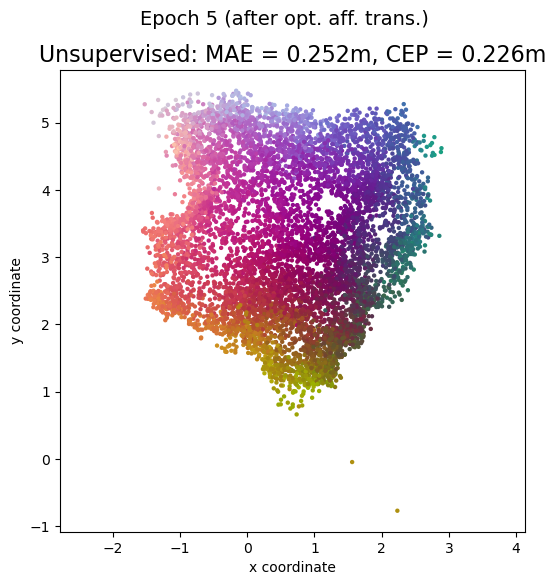

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0749
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


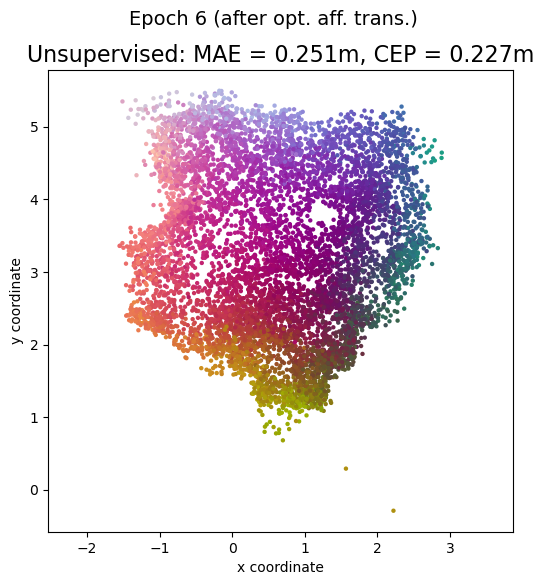

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0755
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


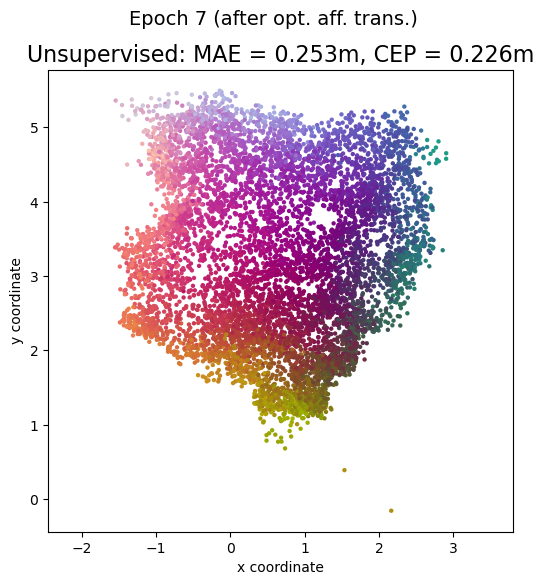

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0755
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


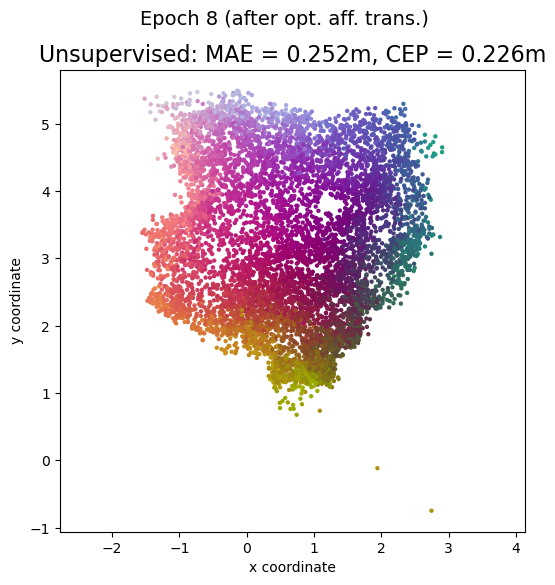

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0755
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


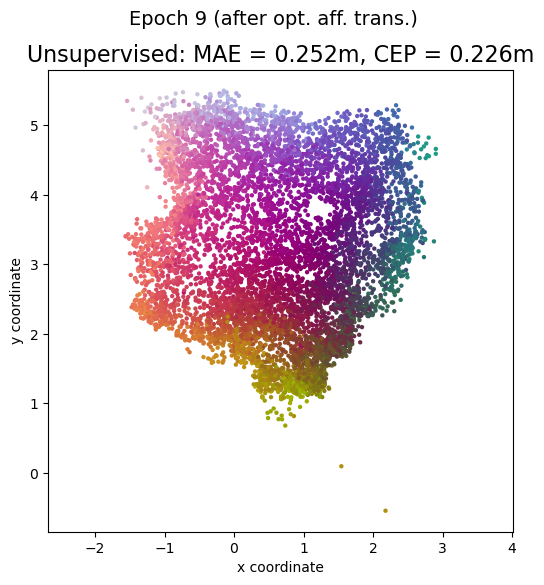

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0746


In [20]:
fcf_model = train_model(robot_training_data, augmented = False)

### Evaluation of Un-Augmented Model on Test Set (After Optimal Affine Transform)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


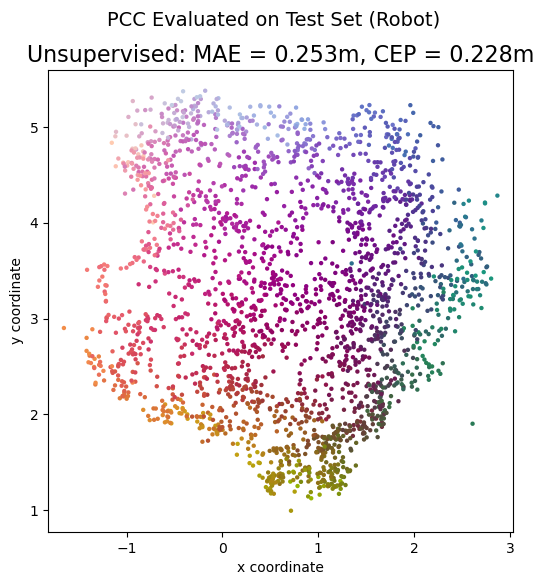

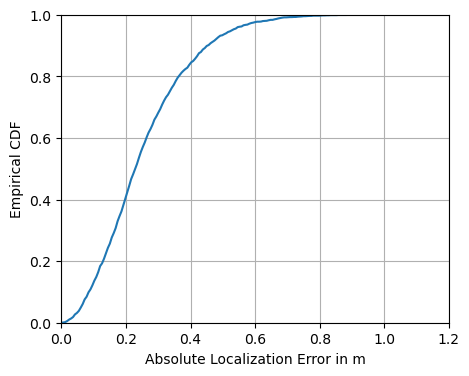

   MAE: 0.253
  DRMS: 0.293
   CEP: 0.228
   R95: 0.529
    KS: 0.138
    CT: 0.988
    TW: 0.989


In [21]:
test_set_robot_predictions = fcf_model.predict(robot_test_data["cluster_features"])
test_set_robot_predictions_transformed = affine_transform_channel_chart(robot_test_data["cluster_positions"], test_set_robot_predictions)
errorvectors, errors, mae, cep = CCEvaluation.compute_localization_metrics(test_set_robot_predictions_transformed, robot_test_data["cluster_positions"])
suptitle = f"PCC Evaluated on Test Set (Robot)"
title = f"Unsupervised: MAE = {mae:.3f}m, CEP = {cep:.3f}m"
CCEvaluation.plot_colorized(test_set_robot_predictions_transformed, robot_test_data["cluster_positions"], suptitle = suptitle, title = title)
metrics = CCEvaluation.compute_all_performance_metrics(test_set_robot_predictions_transformed, robot_test_data["cluster_positions"])
CCEvaluation.plot_error_ecdf(test_set_robot_predictions_transformed, robot_test_data["cluster_positions"])
for metric_name, metric_value in metrics.items():
    print(f"{metric_name.upper().rjust(6, " ")}: {metric_value:.3f}")

### Evaluation of Un-Augmented Model on Human Test Set (After Optimal Affine Transform)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


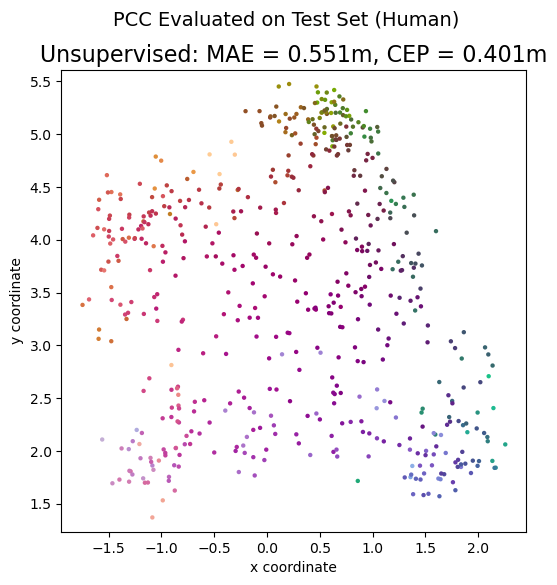

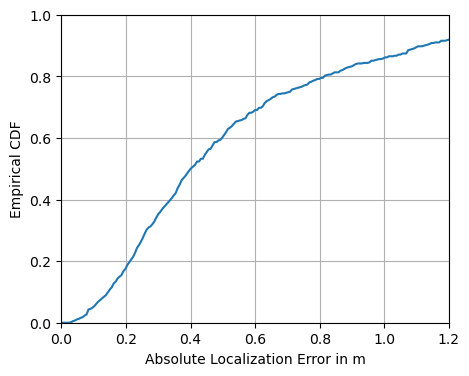

   MAE: 0.551
  DRMS: 0.734
   CEP: 0.401
   R95: 1.431
    KS: 0.258
    CT: 0.946
    TW: 0.959


In [22]:
test_set_human_predictions = fcf_model.predict(human_test_data["cluster_features"]) + espargos_0007.centroid[:2]
test_set_human_predictions_transformed = affine_transform_channel_chart(human_test_data["cluster_positions"], test_set_human_predictions)
errorvectors, errors, mae, cep = CCEvaluation.compute_localization_metrics(test_set_human_predictions_transformed, human_test_data["cluster_positions"])
suptitle = f"PCC Evaluated on Test Set (Human)"
title = f"Unsupervised: MAE = {mae:.3f}m, CEP = {cep:.3f}m"
CCEvaluation.plot_colorized(test_set_human_predictions, human_test_data["cluster_positions"], suptitle = suptitle, title = title)
metrics = CCEvaluation.compute_all_performance_metrics(test_set_human_predictions_transformed, human_test_data["cluster_positions"])
CCEvaluation.plot_error_ecdf(test_set_human_predictions_transformed, human_test_data["cluster_positions"])
for metric_name, metric_value in metrics.items():
    print(f"{metric_name.upper().rjust(6, " ")}: {metric_value:.3f}")

### Augmented Model: Incorporate classical AoA estimates into loss function

Puts channel chart in correct orientation / translation

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


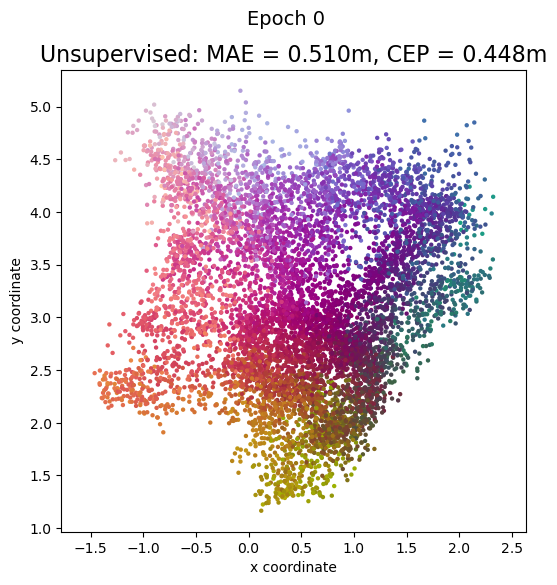

200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: -0.0856
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


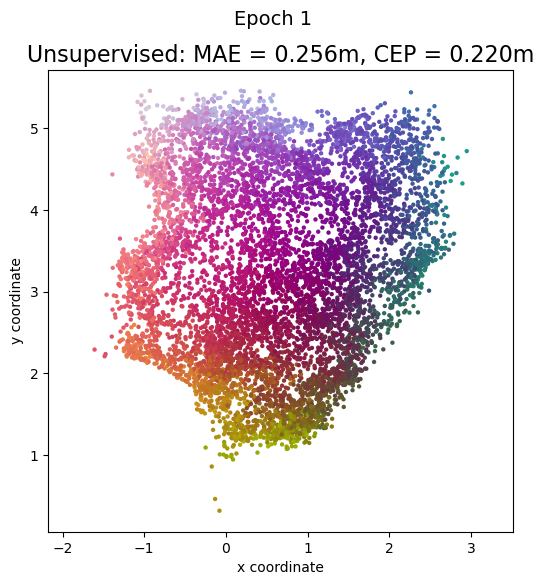

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.3403
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


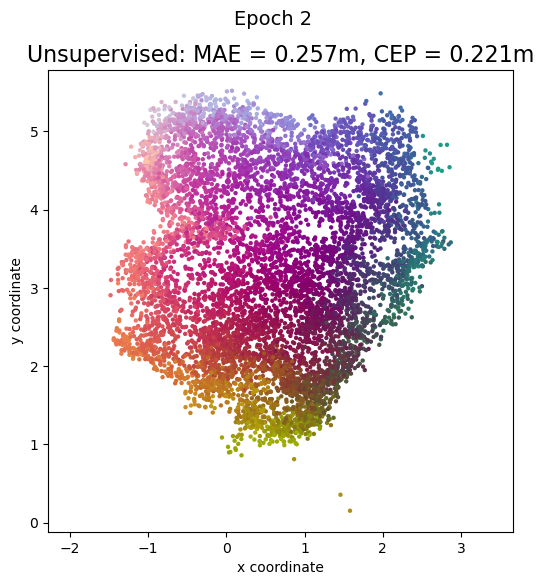

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.3476
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


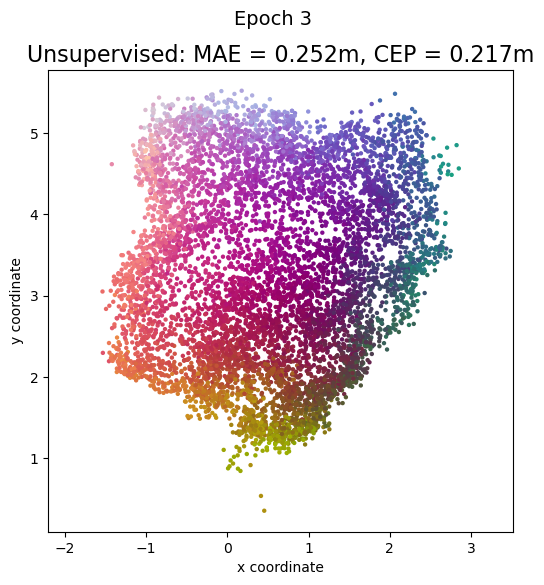

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.3555
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


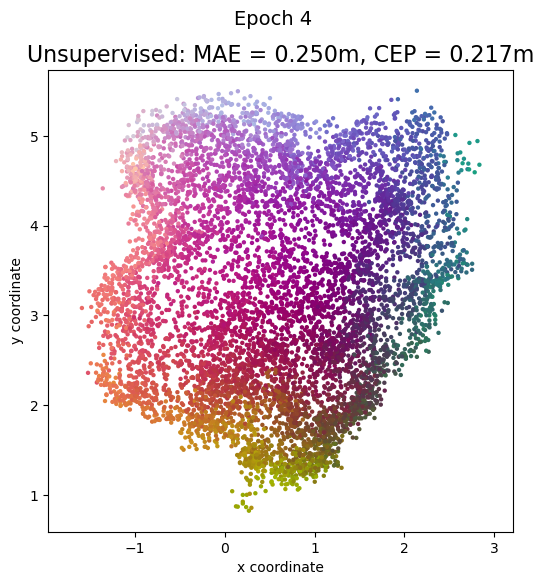

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.3561
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


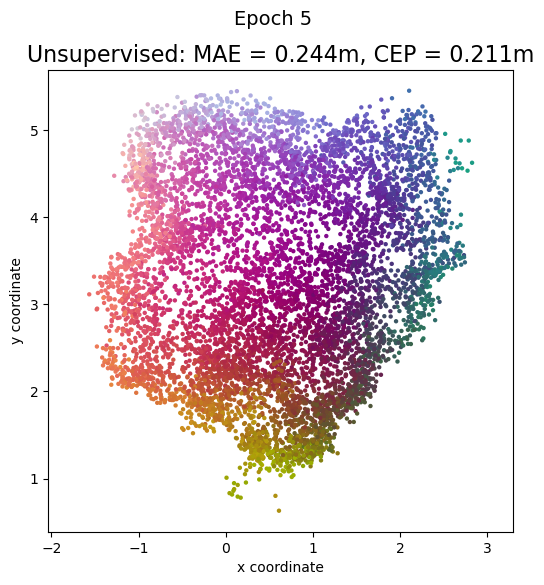

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.3544
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


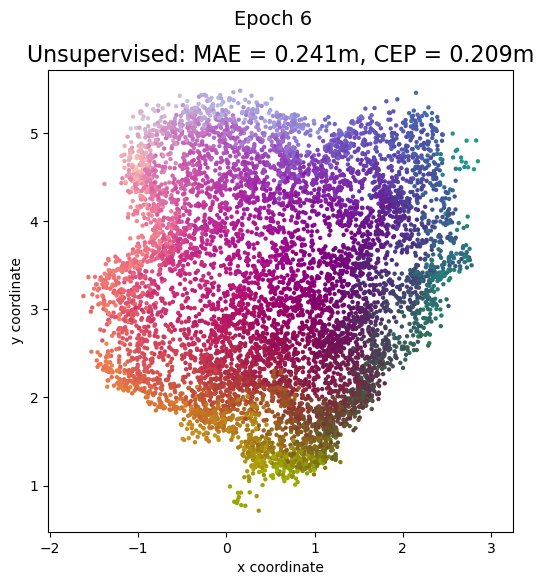

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.3601
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


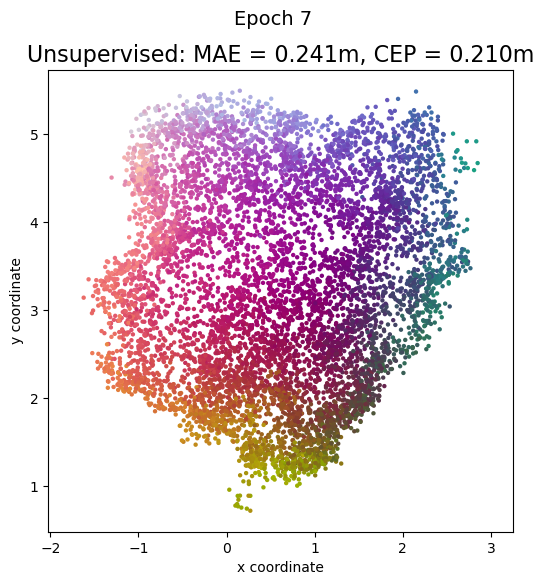

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.3615
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


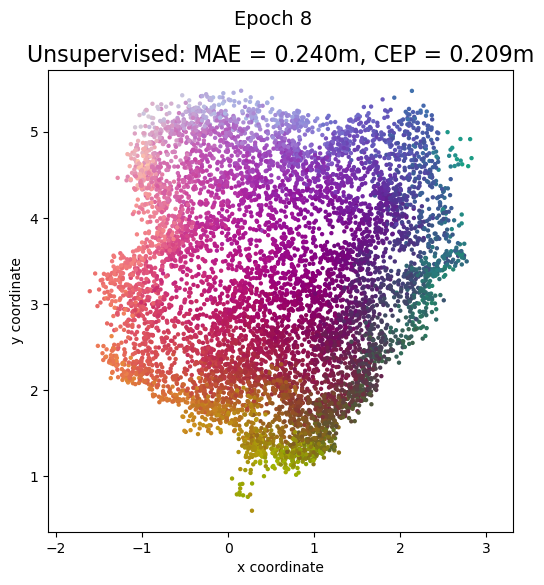

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.3621
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


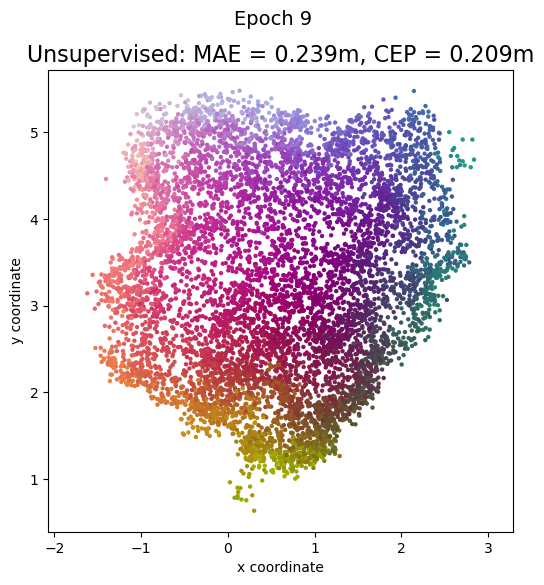

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.3600


In [23]:
augmented_fcf_model = train_model(robot_training_data, augmented = True)

### Evaluation on Training Set

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


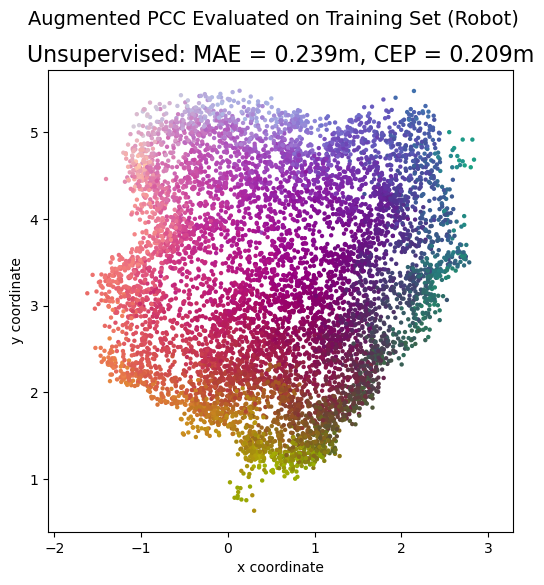

In [24]:
training_set_robot_predictions = augmented_fcf_model.predict(robot_training_data["cluster_features"]) + espargos_0007.centroid[:2]
errorvectors, errors, mae, cep = CCEvaluation.compute_localization_metrics(training_set_robot_predictions, robot_training_data["cluster_positions"])
suptitle = f"Augmented PCC Evaluated on Training Set (Robot)"
title = f"Unsupervised: MAE = {mae:.3f}m, CEP = {cep:.3f}m"
CCEvaluation.plot_colorized(training_set_robot_predictions, robot_training_data["cluster_positions"], suptitle = suptitle, title = title)

### Evaluation on Test Set

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


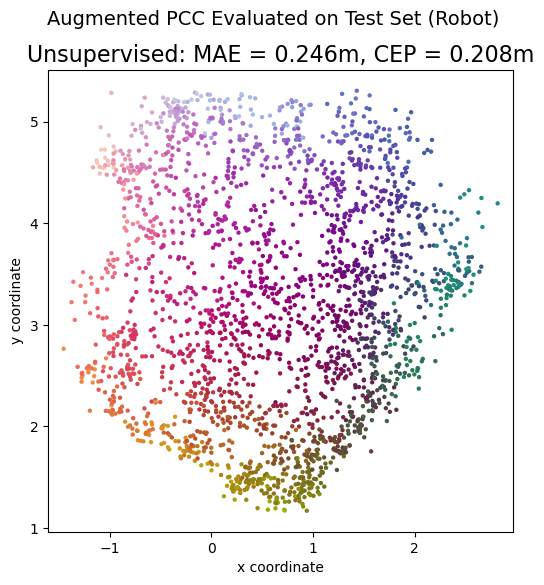

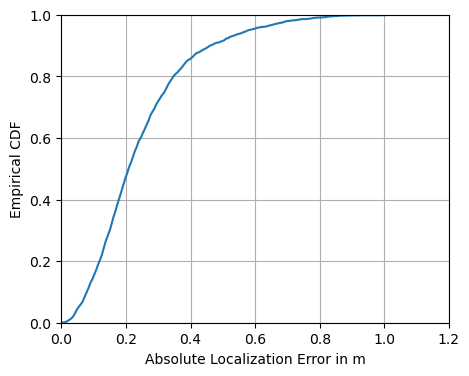

   MAE: 0.246
  DRMS: 0.295
   CEP: 0.208
   R95: 0.581
    KS: 0.129
    CT: 0.988
    TW: 0.990


In [25]:
test_set_robot_predictions = augmented_fcf_model.predict(robot_test_data["cluster_features"]) + espargos_0007.centroid[:2]
errorvectors, errors, mae, cep = CCEvaluation.compute_localization_metrics(test_set_robot_predictions, robot_test_data["cluster_positions"])
suptitle = f"Augmented PCC Evaluated on Test Set (Robot)"
title = f"Unsupervised: MAE = {mae:.3f}m, CEP = {cep:.3f}m"
CCEvaluation.plot_colorized(test_set_robot_predictions, robot_test_data["cluster_positions"], suptitle = suptitle, title = title)
metrics = CCEvaluation.compute_all_performance_metrics(test_set_robot_predictions, robot_test_data["cluster_positions"])
CCEvaluation.plot_error_ecdf(test_set_robot_predictions, robot_test_data["cluster_positions"])
for metric_name, metric_value in metrics.items():
    print(f"{metric_name.upper().rjust(6, " ")}: {metric_value:.3f}")

### Evaluation on Human Test Set

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


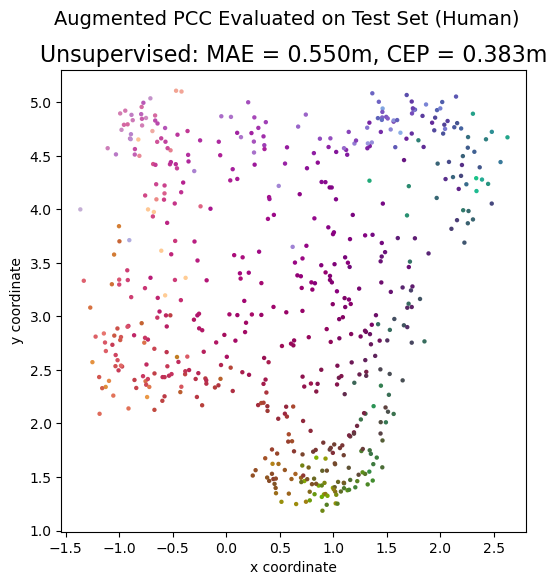

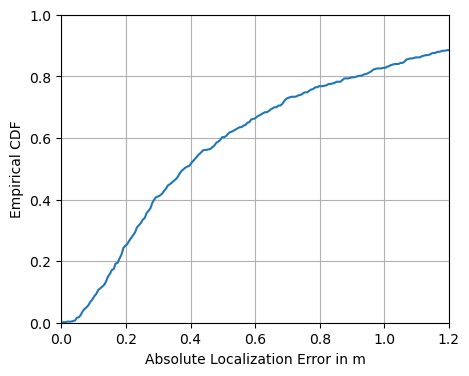

   MAE: 0.550
  DRMS: 0.724
   CEP: 0.383
   R95: 1.565
    KS: 0.236
    CT: 0.959
    TW: 0.972


In [26]:
test_set_human_predictions = augmented_fcf_model.predict(human_test_data["cluster_features"]) + espargos_0007.centroid[:2]
errorvectors, errors, mae, cep = CCEvaluation.compute_localization_metrics(test_set_human_predictions, human_test_data["cluster_positions"])
suptitle = f"Augmented PCC Evaluated on Test Set (Human)"
title = f"Unsupervised: MAE = {mae:.3f}m, CEP = {cep:.3f}m"
CCEvaluation.plot_colorized(test_set_human_predictions, human_test_data["cluster_positions"], suptitle = suptitle, title = title)
metrics = CCEvaluation.compute_all_performance_metrics(test_set_human_predictions, human_test_data["cluster_positions"])
CCEvaluation.plot_error_ecdf(test_set_human_predictions, human_test_data["cluster_positions"])
for metric_name, metric_value in metrics.items():
    print(f"{metric_name.upper().rjust(6, " ")}: {metric_value:.3f}")